<centre><title><h1>Toxic Comment Classification</h1></title></centre>

<center><img src='https://www.blogtyrant.com/wp-content/uploads/2013/01/how-to-get-more-blog-comments.jpg'></center>

<br>
<center><div class="alert alert-block alert-danger" style="margin: 2em;line-height: 1.7em; font-family: Verdana;"><b style="font-size: 18px;">🛑 &nbsp; WARNING:</b><br><br><b>The dataset for this competition contains text that may be considered profane, vulgar, or offensive.</b><br></div></center>

# Imports

In [1]:
import os
import sys
import gc
import random
import re
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from path import Path
from tqdm import tqdm
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go


# About Competition

<p><h3>Description</h3></p>
<p>Discussing things you care about can be difficult. The <b><mark>threat of abuse and harassment</mark></b> online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.</p>
<p>The <b><mark>Conversation AI</mark></b> team, a research initiative founded by <b><mark>Jigsaw</mark></b> and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the <b><mark>Perspective API</mark></b>, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content)</p>
<p>In this competition, we’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. We’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.</p>
<br>
<p><h3>Evaluation</h3></p>
<p>The score is the average of the individual AUCs of each predicted column.</p>

# About Dataset


**`train.csv`**
- The training set, contains comments with their binary labels.

**`test.csv`**
- The test set, contains some comments which are not included in scoring.


# Utils

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

In [3]:
path = "../input/jigsaw-toxic-comment-classification-challenge/"
train_data_path = 'train.csv.zip'
test_data_path = 'test.csv.zip'

train_df = pd.read_csv(path + train_data_path)
print(f'shape of train_dataset: {train_df.shape}')
print('\n\n')
print('========== Train Dataset ==========')
print('\n')
display(train_df.head())

shape of train_dataset: (159571, 8)



========== Train Dataset ==========




,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<br>
<div class='alert alert-info' role='alert'>
    <p><h3><b>Highlights</b></h3></p>
    <p><b>1.</b>Train Dataset contains <b>159571 unique comments</b>.</p>
    <p><b>2.</b>It contains <b>16225 toxic</b> and <b>143346 non-toxic</b>  comments.</p>
    <p class='paragraph'><b>3.</b>Types of toxicity are: <b>toxic</b> , <b>severe_toxic</b> , <b>obscene</b> , <b>threat</b> , <b>insult</b> , <b>identity_hate</b>.</p>
    </div>

# EDA

In [4]:
temp_df = pd.DataFrame()
toxicity = []
comment_type = []
count = []
for col in train_df.columns:
    if col not in ('id','comment_text'):
        toxicity.extend([col,col])
        comment_type.extend(train_df[col].value_counts().keys().tolist())
        count.extend(train_df[col].value_counts().values)

temp_df['toxicity'] = toxicity
temp_df['comment_type'] = np.array(comment_type,dtype=np.str)
temp_df['count'] = count

fig = px.bar(temp_df, x='toxicity', y='count', color='comment_type', title='Value Counts',
             color_discrete_sequence=['#1616A7','#FB0D0D'],width=500)
fig.show()

In [5]:
def preprocessing(text):
    text = re.sub(r" -", "", text)
    text = re.sub(r"\d+:\d+, \w+ \d+, \d+ \(\w+\)","",text) # to remove 21:51, January 11, 2016 (UTC)
    text = re.sub(r"\d+.+\d","",text)
    text = re.sub(r"\n"," ",text)
    text = re.sub(r"\\","",text)
    text = re.sub(r"\.\.\.|\.\."," ",text)
    text = re.sub(r":|_|#"," ",text)
    text = re.sub(r"@|\||\(|\)|!|:|;|\"","",text)
    text = re.sub(r"\.|\?|,"," ", text)
    return text



temp_df = train_df.copy()

temp_df['comment_text'] = temp_df['comment_text'].apply(preprocessing)
temp_df['tokenized_text'] = temp_df['comment_text'].apply(word_tokenize)
#temp_df['comment_text'] = temp_df['comment_text'].apply(lambda x: ' '.join(x.split()))

temp_df['len'] = temp_df['comment_text'].apply(len)

temp_df2 = pd.DataFrame()

temp_df2['len'] = temp_df['len'].value_counts().keys()
temp_df2['count'] = temp_df['len'].value_counts().values

temp_df2 = temp_df2.sort_values('len')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df2['len'].values,y=temp_df2['count'].values,
                         mode='lines', name='len'))
fig.show()

In [6]:
toxic = temp_df[temp_df["toxic"] == 1].reset_index(drop=True)
severe_toxic = temp_df[temp_df["severe_toxic"] == 1].reset_index(drop=True)
obscene = temp_df[temp_df["obscene"] == 1].reset_index(drop=True)
threat = temp_df[temp_df["threat"] == 1].reset_index(drop=True)
insult = temp_df[temp_df["insult"] == 1].reset_index(drop=True)
identity_hate = temp_df[temp_df["identity_hate"] == 1].reset_index(drop=True)

lemma = WordNetLemmatizer()
stem = SnowballStemmer("english")
def most_common(data,n,col):
    top = Counter([stem.stem(lemma.lemmatize(item)) for sublist in data[col] for item in sublist if item.lower() not in STOPWORDS])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ["common_word","count"]
    return temp.style.background_gradient(cmap="Blues")
print("top 20 common words in each toxicity")
print('\n')
print('========== toxic ==========')
display(most_common(toxic, 20, 'tokenized_text'))

print('\n')
print('========== severe_toxic ==========')
display(most_common(severe_toxic, 20, 'tokenized_text'))

print('\n')
print('========== obscene ==========')
display(most_common(obscene, 20, 'tokenized_text'))

print('\n')
print('========== threat ==========')
display(most_common(threat, 20, 'tokenized_text'))

print('\n')
print('========== insult ==========')
display(most_common(insult, 20, 'tokenized_text'))

print('\n')
print('========== identity_hate ==========')
display(most_common(identity_hate, 20, 'tokenized_text'))
print('\n')

top 20 common words in each toxicity


========== toxic ==========


,common_word,count
0,fuck,12249
1,n't,5257
2,suck,4510
3,'s,3875
4,go,3817
5,wikipedia,3597
6,shit,3595
7,nigger,2980
8,u,2880
9,will,2732




========== severe_toxic ==========


,common_word,count
0,fuck,7757
1,suck,3242
2,shit,1880
3,faggot,1573
4,go,1515
5,u,1383
6,as,1196
7,die,1160
8,bitch,1150
9,cunt,1039




========== obscene ==========


,common_word,count
0,fuck,12071
1,suck,3909
2,shit,3190
3,n't,2735
4,go,2707
5,nigger,2621
6,'s,2194
7,u,2173
8,wikipedia,1874
9,bitch,1867




========== threat ==========


,common_word,count
0,die,1120
1,will,731
2,as,729
3,kill,521
4,go,377
5,fuck,271
6,wikipedia,192
7,block,187
8,must,167
9,jim,158




========== insult ==========


,common_word,count
0,fuck,9725
1,suck,3552
2,go,2542
3,n't,2505
4,faggot,2471
5,nigger,2445
6,u,2075
7,'s,1850
8,fat,1842
9,bitch,1794




========== identity_hate ==========


,common_word,count
0,nigger,2645
1,jew,1492
2,fuck,1381
3,fat,1320
4,gay,927
5,die,883
6,faggot,703
7,suck,519
8,nigga,509
9,n't,469


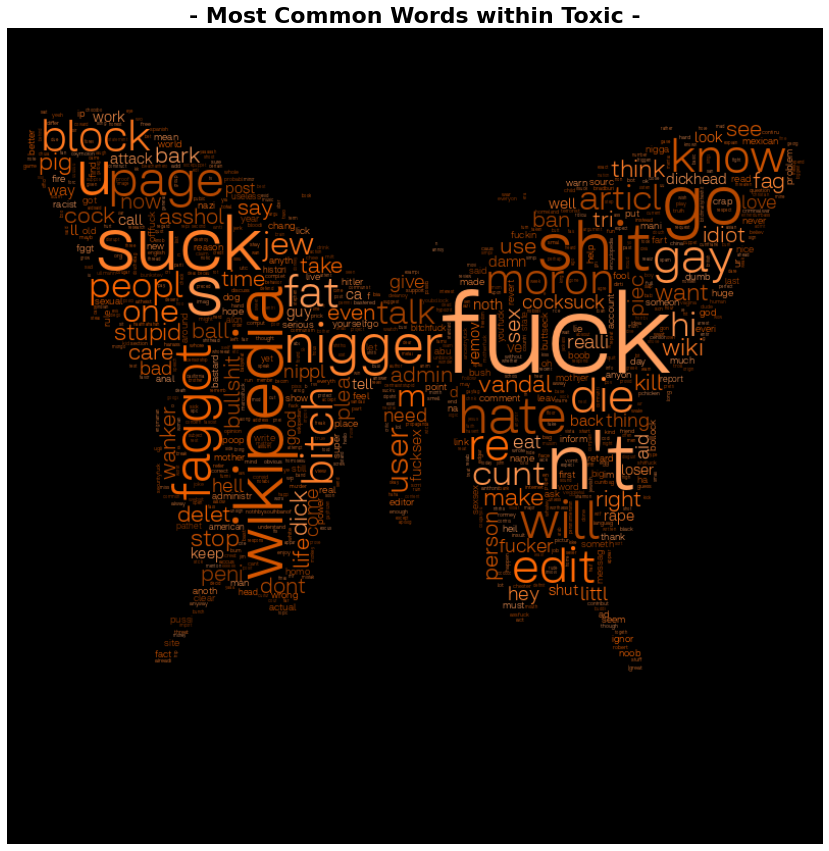

In [7]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(30,70)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in toxic['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/butterfly-shadow-animal-icon-silhouettes-isolated-dark-black-graphical-white-background-184947266.jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=2000,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False, 
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Toxic -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

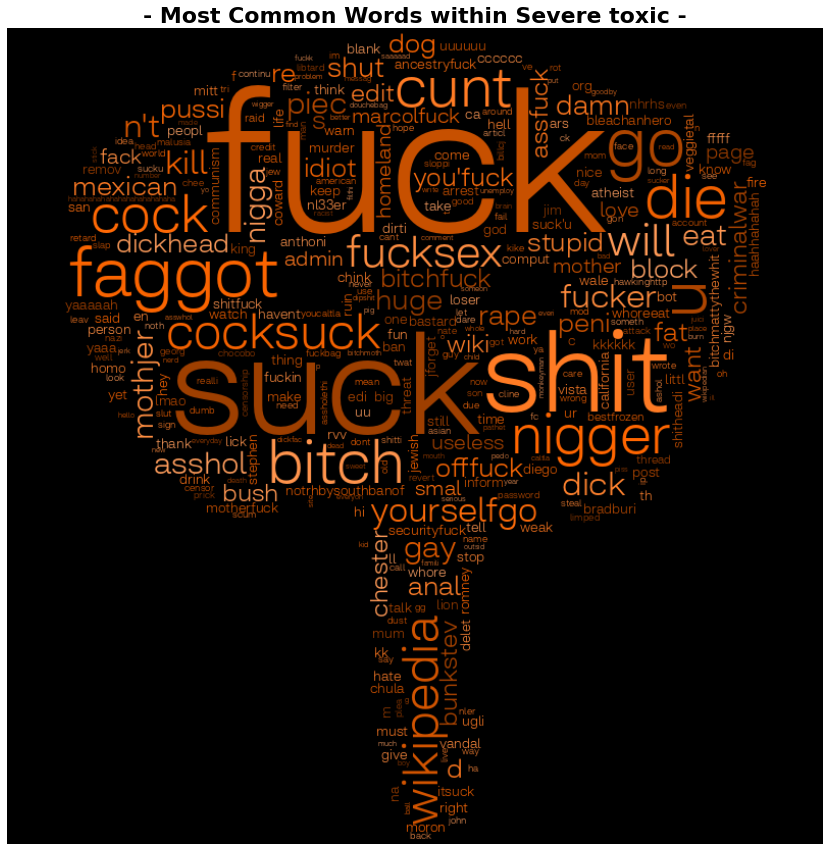

In [8]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(30,70)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in severe_toxic['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/20854.Jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=2000,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False,  
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Severe toxic -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

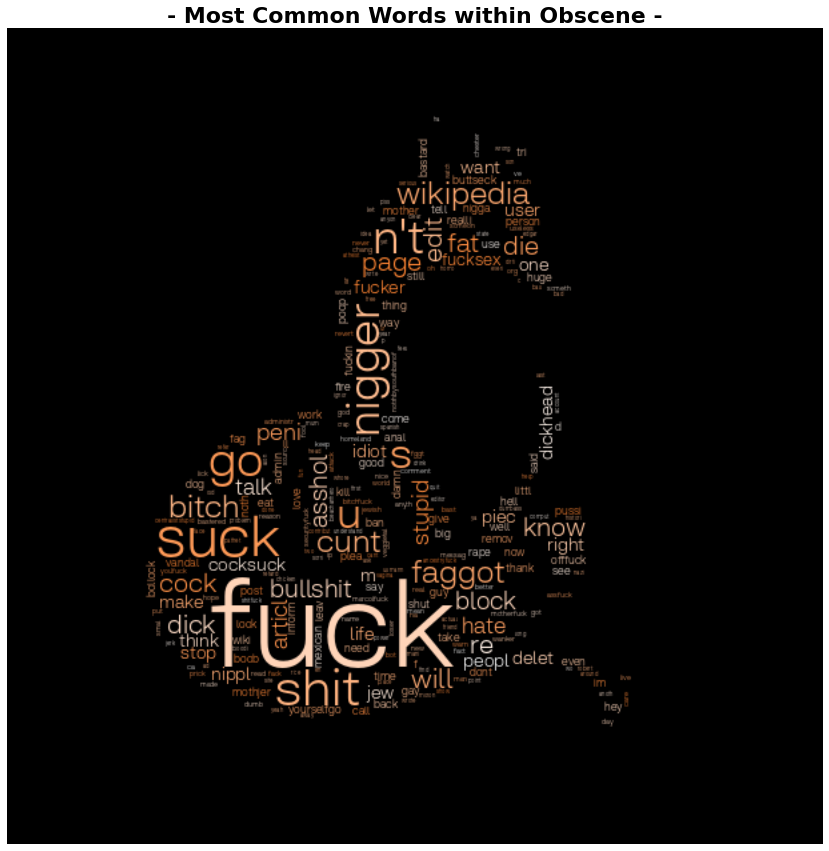

In [9]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(60,100)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in obscene['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/istockphoto-858216614-612x612.jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=2000,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False,  
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Obscene -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

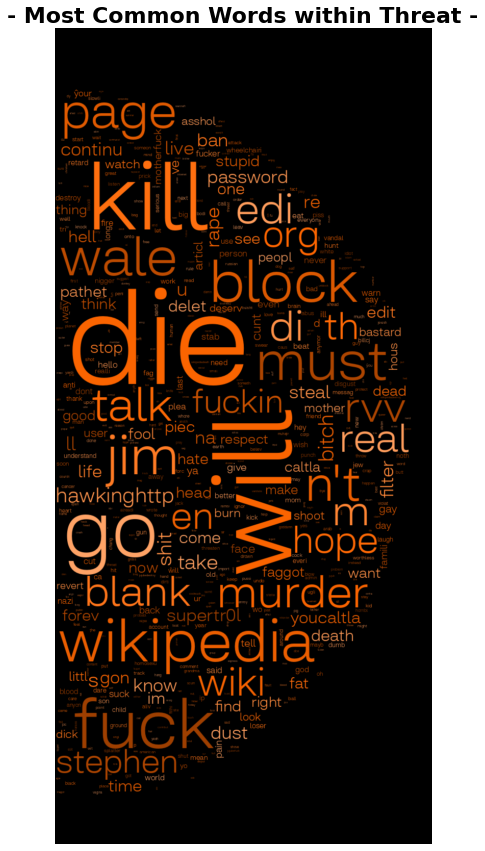

In [10]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(30,70)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in threat['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/Picsart_22-05-18_16-33-42-111.jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=2000,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False,  
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Threat -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

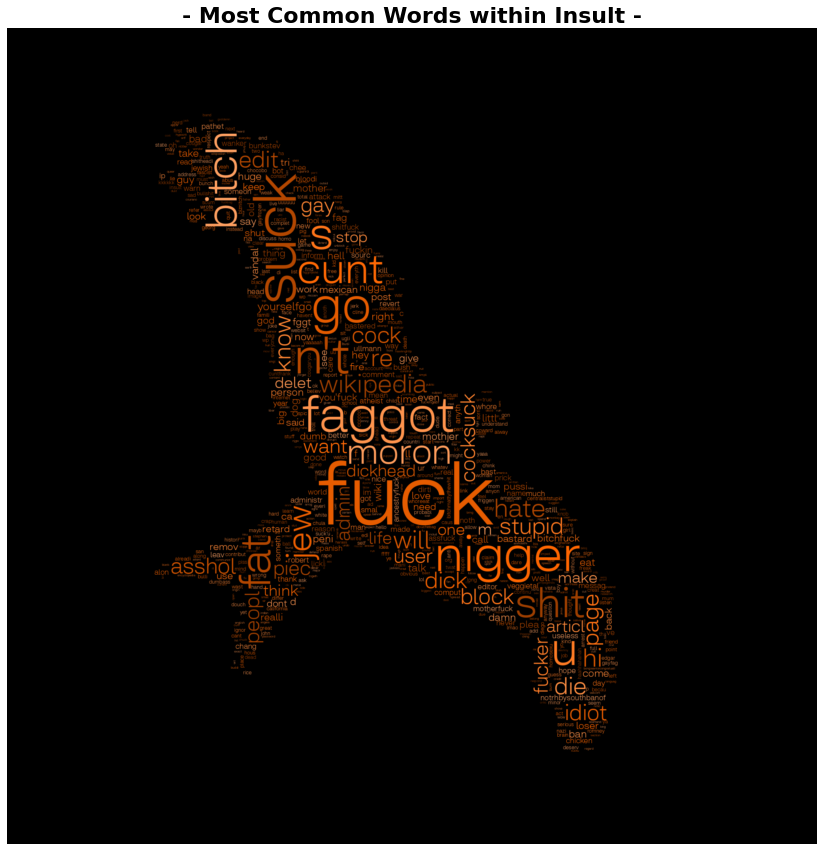

In [11]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(30,70)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in insult['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/red-kite-rapture-black-silhouette-cut-out-and-isolated-on-a-white-background-2C4B3E9.jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=2000,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False,  
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Insult -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

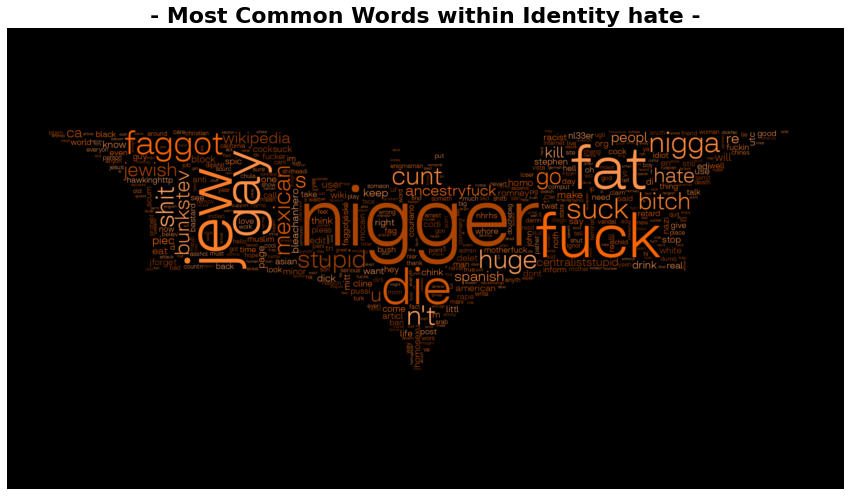

In [12]:
def similer_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h=24
    s=100
    l=random_state.randint(30,70)
    return f'hsl({h}, {s}%, {l}%)'

text = [stem.stem(lemma.lemmatize(item.lower())) for sublist in identity_hate['tokenized_text'] for item in sublist if item.lower() not in STOPWORDS]
text = ' '.join(text)

mask = np.array(Image.open('../input/images/2d27acd5d288284587e13b0411e6e48a.jpg'))
wc = WordCloud(mask=mask,
              background_color='black',
              max_words=500,
              stopwords=STOPWORDS,
              max_font_size=256,
              width=mask.shape[1],
              height=mask.shape[0],
              collocations=False,  
              font_path="../input/font-style/SalmaAlfasans-Light.otf",
              color_func=similer_color_func)

wc.generate(text)
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words within Identity hate -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()